In [1]:
import numpy as np
import pandas as pd
import pickle

from matplotlib import pyplot as plt

import hist
import scipy
from scipy import optimize

In [2]:
datadir = "/home/chardong/y_identification/Venv/save_pkl/df_test_sample_hard_scattering/"
savedir = "/home/chardong/y_identification/Venv/save_plots/"

In [3]:
df = pd.read_pickle(datadir+"df_test_combined_sample_hard_scattering_skim30.pkl")
#df.head()

In [4]:
# y_eta
edges_eta = [0, 0.6, 0.8, 1.15, 1.37, 1.52, 1.81, 2.01, 2.37]

# y_pt
edges_pt_bkg = [20,  25,  30,  35,  40,  45, 50, 65, 490]
edges_pt_sig = edges_pt_bkg

# evt-mu
edges_mu_bkg =  [0., 16., 22., 24., 26., 28., 30., 32., 34., 36., 40., 44., 46., 48., 60]
#[5, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 40]
edges_mu_sig = edges_mu_bkg

# Créer des axes de structure de bins
axis_eta = hist.axis.Variable(edges_eta,    name="eta", label=r"$\eta$")

# Créer des axes de structure de bins
axis_pt_sig = hist.axis.Variable(edges_pt_sig, name='pt', label=r"$p_T$ [GeV]")
axis_pt_bkg = hist.axis.Variable(edges_pt_bkg, name='pt', label=r"$p_T$ [GeV]")

# Créer des axes de structure de bins
axis_mu_sig = hist.axis.Variable(edges_mu_sig, name='evt_mu', label=r"$evt_\mu$")
axis_mu_bkg = hist.axis.Variable(edges_mu_bkg, name='evt_mu', label=r"$evt_\mu$")

In [5]:
# Preselection on photon passin Loose cut-based selection 
df = df.query('y_IsLoose == 1')

In [6]:
# Adding column with absolute eta value, assuming symmetry
df['y_abs_eta'] = np.abs(df['y_eta'])
#df.head()

In [7]:
# Assiging indices correspoding to bins to each event in dataset
# Nouvelles colones eta_bin_.. dans le df assignant chaque valeur de y_abs_eta à un bin de l'histograme axis_... 
df = df.assign(eta_bin = axis_eta.index(df['y_abs_eta']))

# Assiging indices correspoding to bins to each event in dataset
# Nouvelles colones py_bin_.. dans le df assignant chaque valeur de y_abs_eta à un bin de l'histograme axis_... 
df = df.assign(pt_bin_sig = axis_pt_sig.index(df['y_pt']))
df = df.assign(pt_bin_bkg = axis_pt_bkg.index(df['y_pt']))

# Assiging indices correspoding to bins to each event in dataset
df = df.assign(mu_bin_sig = axis_mu_sig.index(df['evt_mu']))       #Mapper les valeur de evt_mu aux bins définis par axis_mu_sig.
df = df.assign(mu_bin_bkg = axis_mu_bkg.index(df['evt_mu']))
#df.head()

In [8]:
df_sig = df.query('truth_label==1')
df_bkg = df.query('truth_label==0')

print(f'    Signal dataset size = {len(df_sig):7d}')
print(f'Background dataset size = {len(df_bkg):7d}')

    Signal dataset size = 2301038
Background dataset size =  186284


In [9]:
df_sig_tight = df_sig[(df_sig["y_IsTight"]==1)]  #bouléen
df_bkg_tight = df_bkg[(df_bkg["y_IsTight"]==1)]

print(f'    Signal dataset size = {len(df_sig_tight):7d}')
print(f'Background dataset size = {len(df_bkg_tight):7d}')

    Signal dataset size = 2132650
Background dataset size =   39568


### Compute efficiency and rejection for cut-based Tight identification

In [10]:
# Histograms and Axes pour 'mu', 'pt' et 'eta'
den_sig = hist.Hist(axis_eta, axis_pt_sig, axis_mu_sig).fill(df_sig["y_abs_eta"], df_sig["y_pt"], df_sig["evt_mu"])   #before cat-base
den_bkg = hist.Hist(axis_eta, axis_pt_bkg, axis_mu_bkg).fill(df_bkg["y_abs_eta"], df_bkg["y_pt"], df_bkg["evt_mu"])


num_sig_tight = hist.Hist(axis_eta, axis_pt_sig, axis_mu_sig).fill(df_sig_tight["y_abs_eta"], 
                                                                       df_sig_tight["y_pt"], df_sig_tight["evt_mu"])   #after cut-base
num_bkg_tight = hist.Hist(axis_eta, axis_pt_bkg, axis_mu_bkg).fill(df_bkg_tight["y_abs_eta"], 
                                                                       df_bkg_tight["y_pt"], df_bkg_tight["evt_mu"])

eff_sig_tight = (num_sig_tight/den_sig).values()
efferr_sig_tight = np.sqrt(eff_sig_tight*(1.-eff_sig_tight)/den_sig.values()) # binomial uncertainty on efficiency

eff_bkg_tight = (num_bkg_tight/den_bkg).values()
efferr_bkg_tight = np.sqrt(eff_bkg_tight*(1.-eff_bkg_tight)/den_bkg.values()) # binomial uncertainty on efficiency


## eff_sig_XXX : (ETA, PT, MU)

# BDT working point optimization

In [11]:
def compute_eff_BDT(df, threshold):
    '''Return efficienty of a given selection on BDT score'''
    r = (df['Original_signal_score'] > threshold).sum() / len(df)
    return r

In [12]:
def find_cut_with_root_scalar(df, target_efficiency):
    '''Find selection on BDT score correponsing to target effeciency'''
    r = scipy.optimize.root_scalar(
        lambda x: compute_eff_BDT(df, x) - target_efficiency, bracket=(0., 1.0), 
        method='brenth', options={'xtol': 1E-5, 'maxiter': 50}
    )
    return r.root

In [13]:
#df_bkg.head()

In [14]:
df_bkg_indexed = df_bkg.set_index(['mu_bin_bkg', 'pt_bin_bkg', 'eta_bin']).sort_index()
df_bkg_indexed

y_pt     y_eta     y_phi  y_convRadius  \
mu_bin_bkg pt_bin_bkg eta_bin                                                
0          0          0        23.172302  0.544748  0.812935   9999.000000   
                      0        23.922916  0.480620  1.075017     36.265739   
                      0        22.555389 -0.539696  2.383196   9999.000000   
                      0        23.910772  0.164627 -1.852649     89.606613   
                      0        22.400295  0.528513  2.170370    296.497345   
...                                  ...       ...       ...           ...   
14         7          7        72.417625  2.058916 -1.865030   9999.000000   
                      7        83.246689 -2.345259 -1.050470     94.960258   
                      7        94.037430 -2.233927  0.532729   9999.000000   
                      8        69.574806 -2.376270 -1.291363    136.820160   
                      8        74.508057 -2.370181 -1.905103   9999.000000   

                               y_convType       weight  truth_label  evt_mu  \
mu_bin_bkg pt_bin_bkg eta_bin                                                 
0          0          0                 0   843.163940          0.0   14.49   
                      0                 3   340.742513          0.0    8.50   
                      0                 0  5354.811757          0.0   13.49   
                      0                 3   113.699228          0.0    4.50   
                      0                 1  8707.345311          0.0   14.49   
...                                   ...          ...          ...     ...   
14         7          7                 0     1.263899          0.0   65.50   
                      7                 1     0.000000          0.0   80.50   
                      7                 0     0.000000          0.0   85.50   
                      8                 1     0.685169          0.0   64.50   
                      8                 0     0.000000          0.0   92.50   

                               y_IsLoose  y_IsTight  y_truth_pt  y_truth_eta  \
mu_bin_bkg pt_bin_bkg eta_bin                                                  
0          0          0             True      False   16.249475     0.521072   
                      0             True      False   10.706585     0.480694   
                      0             True      False   19.790754    -0.539809   
                      0             True      False -999.000000  -999.000000   
                      0             True      False   10.428835     0.528653   
...                                  ...        ...         ...          ...   
14         7          7             True       True   69.046707     2.059837   
                      7             True       True   44.333076    -2.346262   
                      7             True      False   62.275867    -2.231258   
                      8             True       True   50.108772    -2.375190   
                      8             True      False   49.268169    -2.372822   

                               Original_background_score  \
mu_bin_bkg pt_bin_bkg eta_bin                              
0          0          0                         0.911685   
                      0                         0.995991   
                      0                         0.752417   
                      0                         0.867384   
                      0                         0.995931   
...                                                  ...   
14         7          7                         0.039097   
                      7                         0.604148   
                      7                         0.142775   
                      8                         0.054820   
                      8                         0.550190   

                               Original_signal_score  \
mu_bin_bkg pt_bin_bkg eta_bin                          
0          0          0                     0.088315   
   

In [15]:
bdt_cut_same_background_efficiency_tight = {} # store optimal BDT thresholds

for (ieta, ipt, imu), eff_tight in np.ndenumerate(eff_bkg_tight): 
    # select subsample of events corresponding to the current (eta,mu) bin
    
    df_bin = df_bkg_indexed.loc[imu, ipt, ieta] # using indexed df to speedup selection
    
    # find and store optimal BDT selection for current bin
    cut_BDT = find_cut_with_root_scalar(df_bin, target_efficiency = eff_tight)
    bdt_cut_same_background_efficiency_tight[imu, ipt, ieta] = cut_BDT

bdt_cut_same_background_efficiency_tight = pd.Series(bdt_cut_same_background_efficiency_tight).sort_index()
bdt_cut_same_background_efficiency_tight.index.names = ['mu_bin_bkg', 'pt_bin_bkg', 'eta_bin']

bdt_cut_same_background_efficiency_tight

mu_bin_bkg  pt_bin_bkg  eta_bin
0           0           0          0.781734
                        1          0.772287
                        2          0.776044
                        3          0.660955
                        4          0.750000
                                     ...   
13          7           3          0.670966
                        4          0.467452
                        5          0.585730
                        6          0.798227
                        7          0.756970
Length: 896, dtype: float64

In [16]:
df = df.merge(bdt_cut_same_background_efficiency_tight.rename('BDTcut_samebkgeff_tight'), 
             on=['mu_bin_bkg', 'pt_bin_bkg', 'eta_bin'], how="left")
df = df.assign(pass_BDTcut_samebkgeff_tight = df['Original_signal_score'] > df['BDTcut_samebkgeff_tight'])

In [17]:
df.drop('BDTcut_samebkgeff_tight',axis=1,inplace=True)

In [18]:
#df.head()

### Compute efficiency and rejection for BDT working point

In [19]:
df_sig = df.query('truth_label == 1')
df_bkg = df.query('truth_label == 0')

In [20]:
#num and efficiency for the BDT

df_sig_bdt = df_sig.query('pass_BDTcut_samebkgeff_tight')
num_sig_bdt = hist.Hist(axis_eta, axis_pt_sig, axis_mu_sig).fill(df_sig_bdt["y_abs_eta"], 
                                                                     df_sig_bdt["y_pt"], df_sig_bdt["evt_mu"])

df_bkg_bdt = df_bkg.query('pass_BDTcut_samebkgeff_tight')
num_bkg_bdt = hist.Hist(axis_eta, axis_pt_bkg, axis_mu_bkg).fill(df_bkg_bdt["y_abs_eta"], 
                                                                     df_bkg_bdt["y_pt"], df_bkg_bdt["evt_mu"])

eff_sig_bdt = (num_sig_bdt / den_sig).values()
efferr_sig_bdt = np.sqrt(eff_sig_bdt * (1 - eff_sig_bdt) / den_sig.values())

eff_bkg_bdt = (num_bkg_bdt / den_bkg).values()
efferr_bkg_bdt = np.sqrt(eff_bkg_bdt * (1 - eff_bkg_bdt) / den_bkg.values())

In [21]:
# Convertir les histogrammes en listes ou arrays pour tracer avec matplotlib
mu_sig = axis_mu_sig.centers
mu_bkg = axis_mu_bkg.centers

### eff_sig_XXX : (ETA, PT, MU)

# Mu into ETA & pT bin

In [26]:
for i in range(eff_sig_bdt.shape[2]):  # Parcourir les colonnes
    print(f"Valeurs de eff_sig_bdt[:, :, {i}]:")
    print(eff_sig_bdt[i:, :,])
    print()

Valeurs de eff_sig_bdt[:, :, 0]:
[[[0.93778802 0.89845475 0.95238095 0.89705882 0.83916084 0.91919192
   0.92216981 0.89616253 0.82926829 0.89830508 0.89416058 0.88582677
   0.89787234 0.87176326]
  [0.93781095 0.92009401 0.92307692 0.9058296  0.92063492 0.92307692
   0.87969925 0.89563107 0.88888889 0.8962585  0.90095238 0.8647541
   0.90430622 0.90645586]
  [0.92170819 0.94623656 0.88926174 0.93948127 0.95156695 0.9125964
   0.94301994 0.92634561 0.94405594 0.90304183 0.93349169 0.8994709
   0.97297297 0.90652819]
  [0.97041847 0.97477597 0.95197133 0.96189225 0.96494709 0.96664443
   0.93346008 0.95872801 0.95426357 0.94364292 0.95461578 0.94158879
   0.90707351 0.93229544]
  [0.98216159 0.95744681 0.97121535 0.96183206 0.95413759 0.97114428
   0.96487985 0.95228216 0.95365006 0.95610687 0.91247265 0.92166667
   0.90018149 0.93283951]
  [0.98442368 0.9781457  0.95037594 0.93603936 0.97286296 0.96414853
   0.96321839 0.94179894 0.93956835 0.94382022 0.93600764 0.9556541
   0.96464646

In [28]:
for i in range(eff_sig_tight.shape[2]):  # Parcourir les colonnes
    print(f"Valeurs de eff_sig_bdt[:, :, {i}]:")
    print(eff_sig_tight[i:, :,])
    print()

Valeurs de eff_sig_bdt[:, :, 0]:
[[[0.88940092 0.84547461 0.86967419 0.85504202 0.79020979 0.84242424
   0.8254717  0.80586907 0.79132791 0.79044684 0.82116788 0.78740157
   0.80851064 0.77681874]
  [0.8880597  0.88014101 0.88859416 0.86995516 0.85260771 0.88701923
   0.83458647 0.86165049 0.84876543 0.86564626 0.81904762 0.83606557
   0.83732057 0.80632411]
  [0.83985765 0.86175115 0.86241611 0.86455331 0.86609687 0.89460154
   0.85470085 0.83852691 0.84615385 0.8460076  0.87648456 0.85714286
   0.84324324 0.83976261]
  [0.91341991 0.91536674 0.89462366 0.90013141 0.9047619  0.89993329
   0.9017744  0.88565629 0.90465116 0.89134355 0.87209902 0.89252336
   0.86130374 0.87074584]
  [0.93494229 0.90549233 0.92324094 0.89790076 0.92023928 0.91542289
   0.89371534 0.91078838 0.89687138 0.87659033 0.89277899 0.885
   0.87477314 0.86617284]
  [0.94392523 0.91059603 0.89924812 0.90282903 0.92130258 0.91293214
   0.92413793 0.89814815 0.91510791 0.89628349 0.90544413 0.89578714
   0.91414141 

/tmp/ipykernel_25758/2663836527.py:55: RuntimeWarning: invalid value encountered in divide
  rax.plot(mu_sig, eff_sig_bdt[eta_idx, pt_idx, :] / eff_sig_tight[eta_idx, pt_idx, :], 'x', color='red')


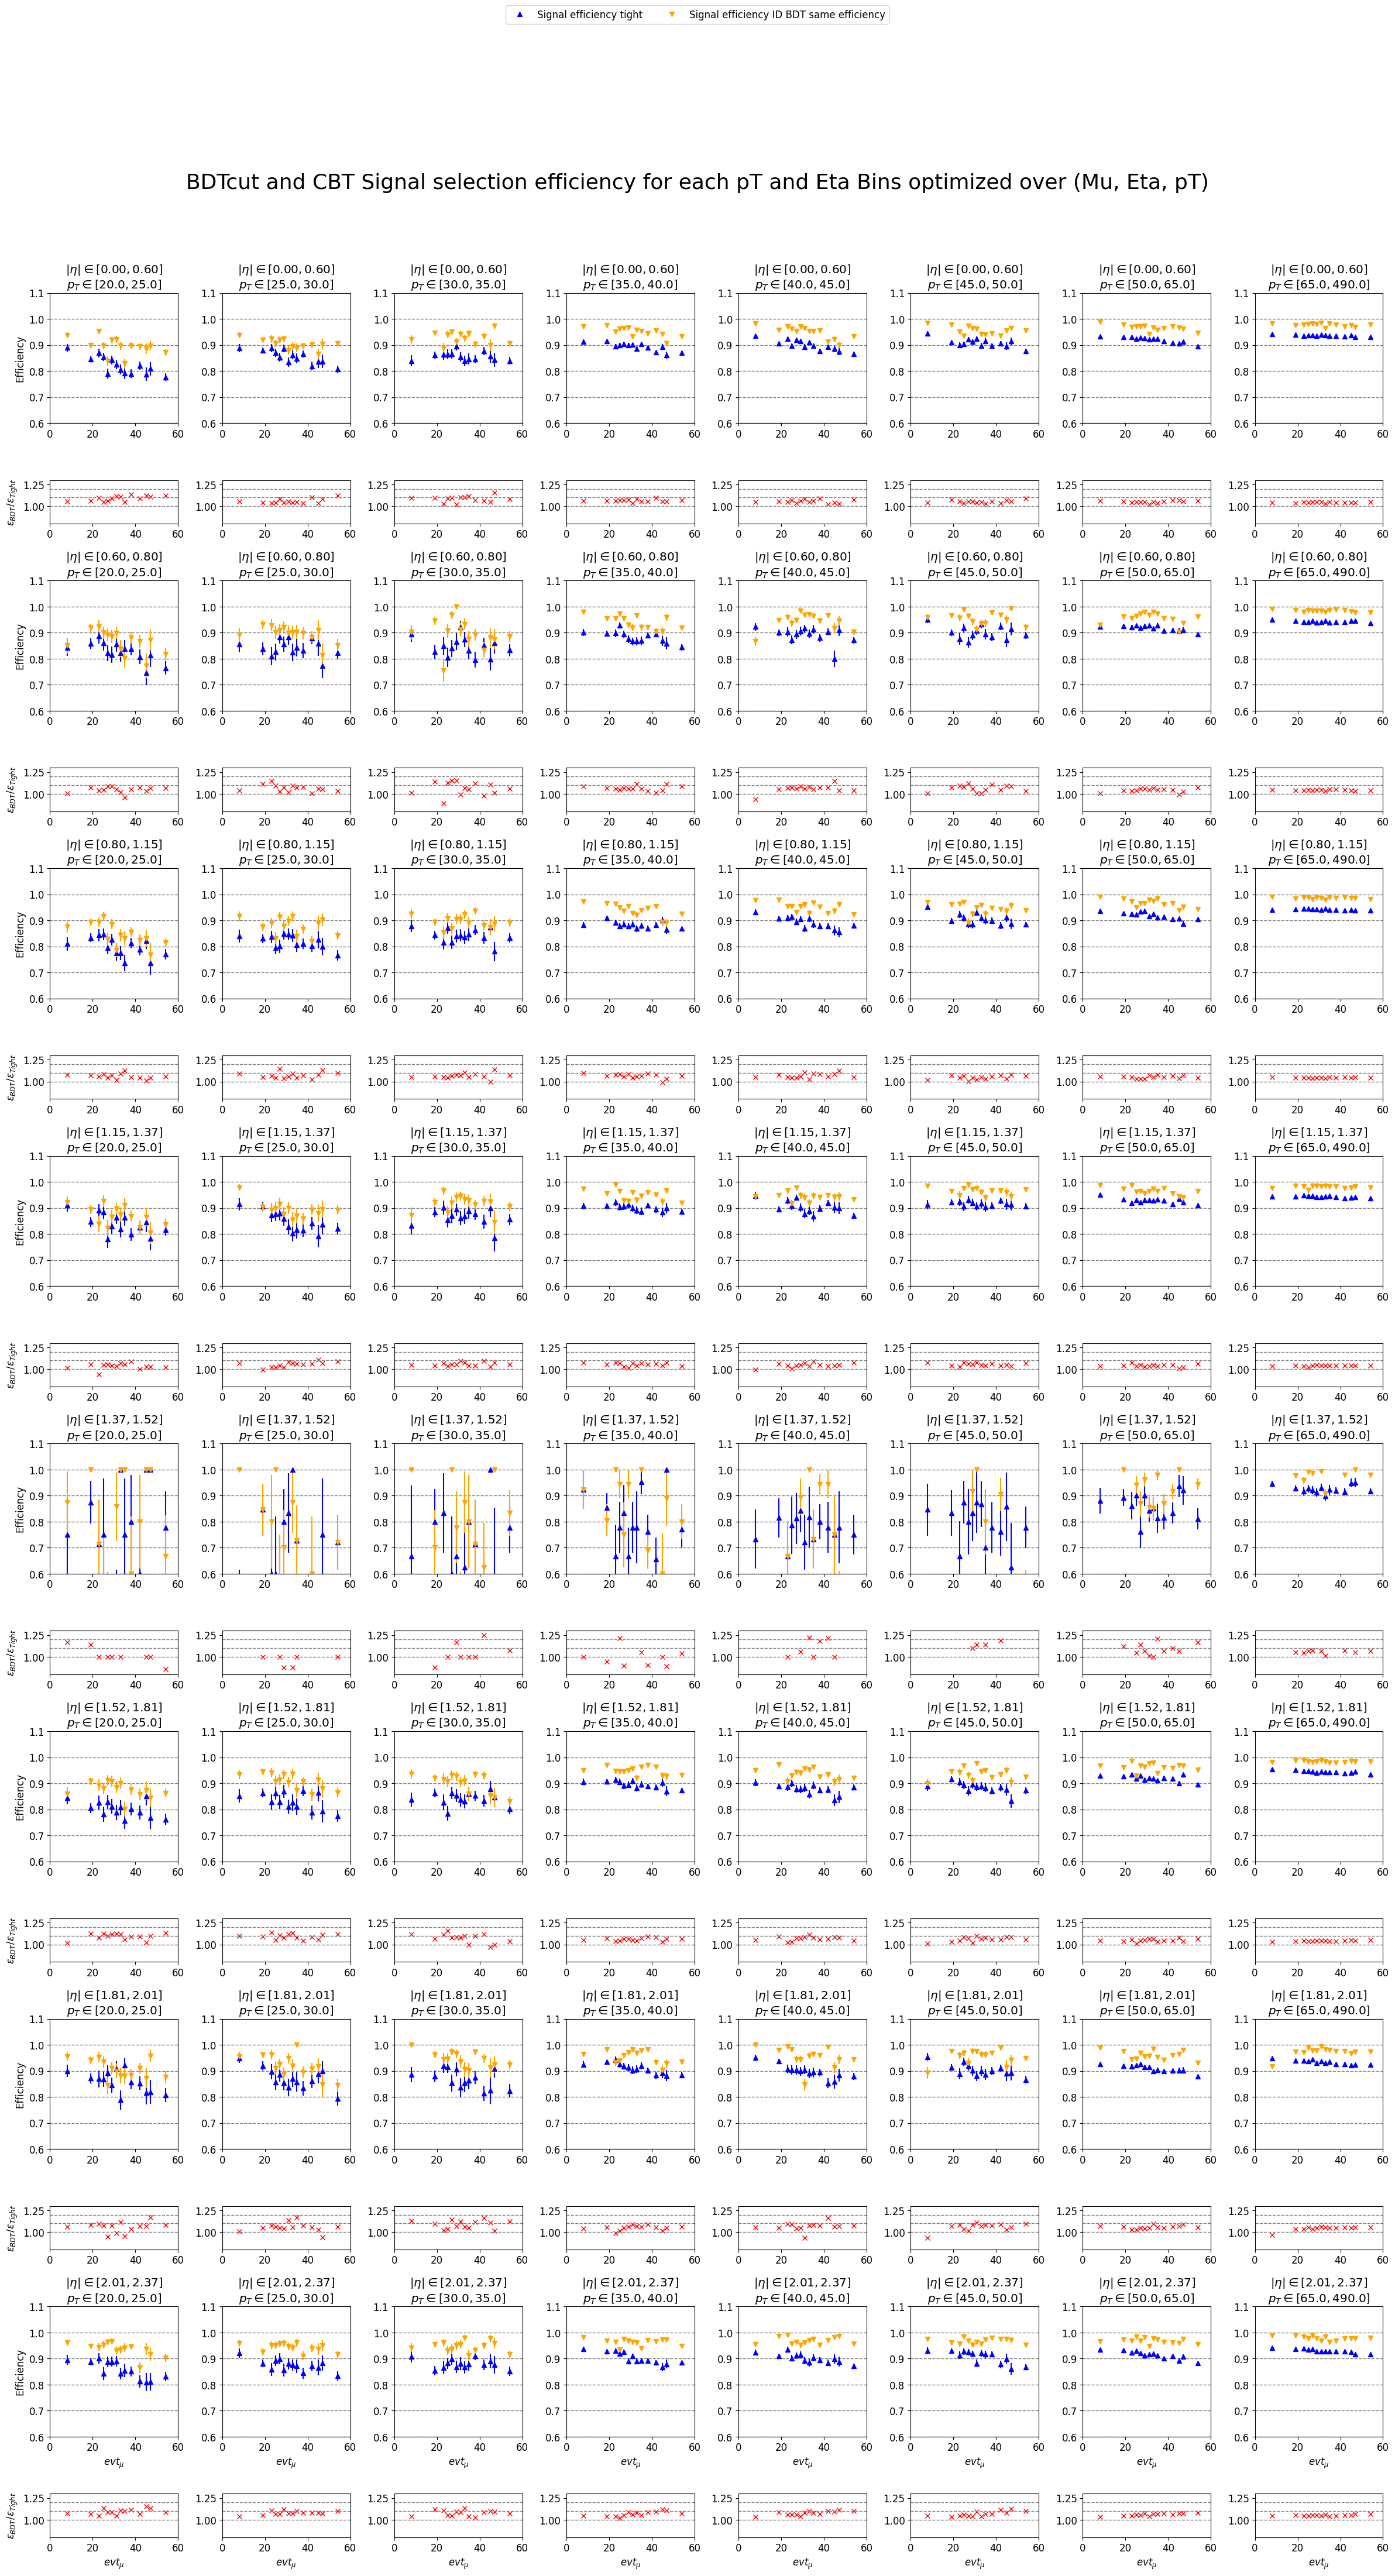

In [24]:
plt.rcParams.update({'font.size': 12})

# Nombre de sous-graphiques
num_eta_bins = len(axis_eta)
num_pt_bins = len(axis_pt_sig)

# Créez une figure avec une grille de subplots
fig, axs = plt.subplots(nrows=2*num_eta_bins, ncols=num_pt_bins, figsize=(24, 42),
                        gridspec_kw={"height_ratios": [3, 1] * num_eta_bins})
fig.subplots_adjust(hspace=0.2, wspace=0.5)

# Initialisation des handles et labels pour la légende
handles = []
labels = []

# Boucle sur les bins eta et pt
for eta_idx in range(num_eta_bins):
    for pt_idx in range(num_pt_bins):
        
        ax = axs[2*eta_idx, pt_idx]  # Subplot pour l'efficacité
        rax = axs[2*eta_idx+1, pt_idx]  # Subplot pour le ratio
        
        # Tracer les efficacités avec barres d'erreur
    
        ax.axhline(y=0.6, color='grey', linestyle='--', linewidth=1)
        ax.axhline(y=0.7, color='grey', linestyle='--', linewidth=1)
        ax.axhline(y=0.8, color='grey', linestyle='--', linewidth=1)
        ax.axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
        ax.axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
        
        errorbar_tight = ax.errorbar(mu_sig, eff_sig_tight[eta_idx, pt_idx, :], efferr_sig_tight[eta_idx, pt_idx, :],
                                     fmt='^', linestyle='', color='blue',
                                     label='Signal efficiency tight' if eta_idx == 0 and pt_idx == 0 else "")
        errorbar_bdt = ax.errorbar(mu_sig, eff_sig_bdt[eta_idx, pt_idx, :], efferr_sig_bdt[eta_idx, pt_idx, :],
                                   fmt='v', linestyle='', color='orange',
                                   label='Signal efficiency ID BDT same efficiency' if eta_idx == 0 and pt_idx == 0 else "")

        # Extraction des lignes pour la légende lors du premier subplot
        if eta_idx == 0 and pt_idx == 0:
            handles.append(errorbar_tight[0])
            labels.append('Signal efficiency tight')
            handles.append(errorbar_bdt[0])
            labels.append('Signal efficiency ID BDT same efficiency')

        # Titre et labels des axes
        ax.set_title(f"$|\\eta| \in [{edges_eta[eta_idx]:.2f}, {edges_eta[eta_idx+1]:.2f}]$\n$p_T \in [{edges_pt_sig[pt_idx]:.1f}, {edges_pt_sig[pt_idx+1]:.1f}]$")
        ax.set_ylim(0.6, 1.1)
        ax.set_xlim([0.0, 60])
        if pt_idx == 0:
            ax.set_ylabel('Efficiency')
        if eta_idx == num_eta_bins - 1:
            ax.set_xlabel('$evt_{\mu}$')

        # Ratio entre BDT et Tight
        rax.plot(mu_sig, eff_sig_bdt[eta_idx, pt_idx, :] / eff_sig_tight[eta_idx, pt_idx, :], 'x', color='red')
        rax.axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
        rax.axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
        rax.axhline(y=1.2, color='grey', linestyle='--', linewidth=1)
        rax.set_ylim(0.80, 1.3)
        rax.set_xlim([0.0, 60])
        if pt_idx == 0:
            rax.set_ylabel(r'$\epsilon_{BDT}/\epsilon_{Tight}$')
        if eta_idx == num_eta_bins - 1:
            rax.set_xlabel('$evt_{\mu}$')

# Ajouter une légende globale à la figure
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=12)

# Titre global de la figure
fig.suptitle('BDTcut and CBT Signal selection efficiency for each pT and Eta Bins optimized over (Mu, Eta, pT)', fontsize=26)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()


/tmp/ipykernel_25758/1484165956.py:38: RuntimeWarning: invalid value encountered in divide
  ratio = np.array(eff_sig_bdt[eta_idx, pt_idx, :]) / np.array(eff_sig_tight[eta_idx, pt_idx, :])


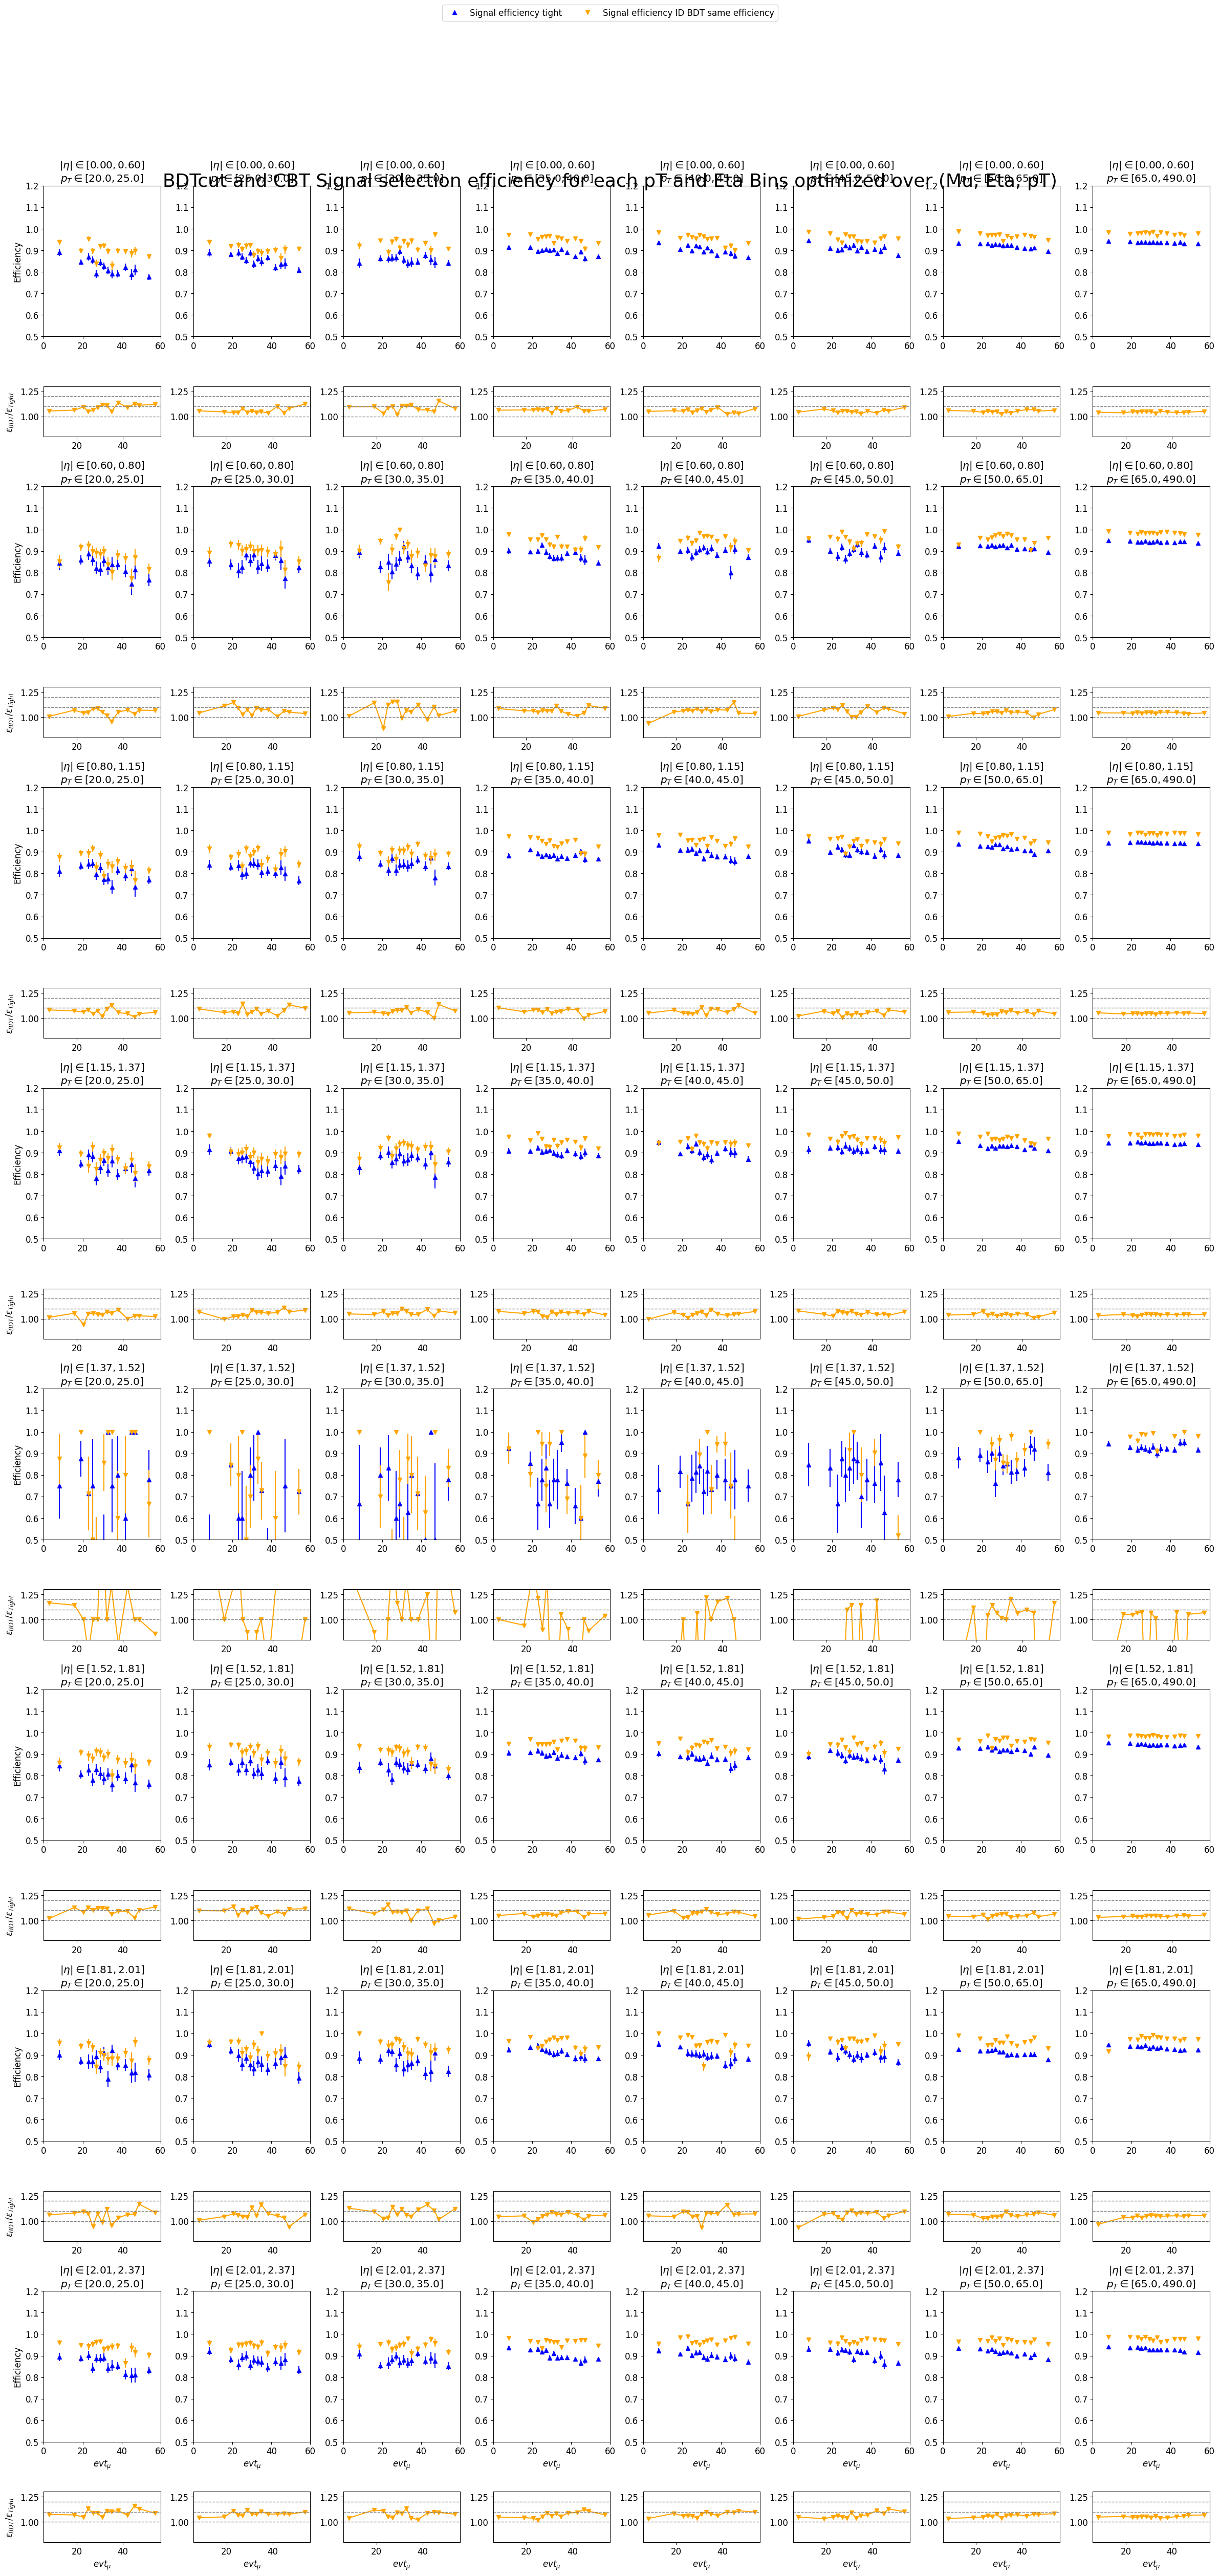

In [25]:
# Number of subplots
num_eta_bins = len(axis_eta)  
num_mu_bins = len(axis_mu_sig)  
num_pt_bins = len(axis_pt_sig)

# Create subplots
fig, axs = plt.subplots(nrows=2*num_eta_bins, ncols=num_pt_bins, figsize=(24, 48), 
                        gridspec_kw={"height_ratios": [3, 1] * num_eta_bins})
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Initialize handles and labels for the legend
handles = []
labels = []

# Loop over eta and pt bins
for eta_idx in range(num_eta_bins):
    for pt_idx in range(num_pt_bins):
        ax = axs[2*eta_idx, pt_idx]  # Subplot for efficiency
        rax = axs[2*eta_idx+1, pt_idx]  # Subplot for ratio

        # Errorbar for tight efficiency
        errorbar_tight = ax.errorbar(mu_sig, eff_sig_tight[eta_idx, pt_idx, :], efferr_sig_tight[eta_idx, pt_idx, :], 
                                     fmt='^', linestyle='', color='blue', 
                                     label='Signal efficiency tight' if eta_idx == 0 and pt_idx == 0 else "")
        # Errorbar for BDT efficiency
        errorbar_bdt = ax.errorbar(mu_sig, eff_sig_bdt[eta_idx, pt_idx, :], efferr_sig_bdt[eta_idx, pt_idx, :], 
                                   fmt='v', linestyle='', color='orange', 
                                   label='Signal efficiency ID BDT same efficiency' if eta_idx == 0 and pt_idx == 0 else "")

        # Extract lines for the legend
        if eta_idx == 0 and pt_idx == 0:
            handles.append(errorbar_tight[0])
            labels.append('Signal efficiency tight')
            handles.append(errorbar_bdt[0])
            labels.append('Signal efficiency ID BDT same efficiency')

        # Ratio between BDT and Tight
        ratio = np.array(eff_sig_bdt[eta_idx, pt_idx, :]) / np.array(eff_sig_tight[eta_idx, pt_idx, :])
        rax.plot(mu_sig, ratio, 'v-', color='orange')

        # Horizontal lines for reference
        rax.axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
        rax.axhline(y=1.2, color='grey', linestyle='--', linewidth=1)
        rax.axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
        rax.set_ylim(0.80, 1.3)

        # Title and axis labels
        ax.set_title(f"$|\eta| \in [{edges_eta[eta_idx]:.2f}, {edges_eta[eta_idx+1]:.2f}]$\n$p_T \in [{edges_pt_sig[pt_idx]:.1f}, {edges_pt_sig[pt_idx+1]:.1f}]$")
        ax.set_ylim(0.5, 1.2)
        ax.set_xlim([0.0, 60])
        if pt_idx == 0:
            ax.set_ylabel('Efficiency')
            rax.set_ylabel(r'$\epsilon_{BDT}/\epsilon_{Tight}$')
        if eta_idx == num_eta_bins - 1:
            rax.set_xlabel('$evt_{\mu}$')
            ax.set_xlabel('$evt_{\mu}$')

# Add a global legend to the figure
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=12)

fig.suptitle('BDTcut and CBT Signal selection efficiency for each pT and Eta Bins optimized over (Mu, Eta, pT)', fontsize=26)


plt.tight_layout()


plt.show()
